In [272]:
import h5py
import numpy as np
import scipy.io
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
import pandas as pd


%matplotlib inline 

# 1. Data Cleaning and Preprocessing (for dataset A)

In [3]:
dataA = scipy.io.loadmat('./DataA.mat')
dataB = scipy.io.loadmat('./DataB.mat')
dataC = scipy.io.loadmat('./DataC.mat')

print('Succesfully loaded data!')
print("Data A shape:", dataA['fea'].shape)
print("Data B shape:", dataB['fea'].shape)
print("Data C shape:", dataC['fea'].shape)

Succesfully loaded data!
Data A shape: (19000, 81)
Data B shape: (2066, 784)
Data C shape: (2100, 21)


## Replace missing values (NaN) by mean value

In [17]:
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)

a_features = dataA['fea']

imp.fit(a_features)

a_features_clean = imp.transform(a_features)

## Normalize data

In [95]:
min_max_scaler = MinMaxScaler()

X_train_minmax = min_max_scaler.fit_transform(a_features_clean)
X_train_standardized = scale(X_train_minmax)

## Plot histograms of feature 9 and 24

(array([  1.00000000e+00,   4.00000000e+00,   7.90000000e+01,
          1.97400000e+03,   6.39100000e+03,   7.86000000e+03,
          2.35400000e+03,   3.15000000e+02,   2.00000000e+01,
          2.00000000e+00]),
 array([-2734. , -2220.5, -1707. , -1193.5,  -680. ,  -166.5,   347. ,
          860.5,  1374. ,  1887.5,  2401. ]),
 <a list of 10 Patch objects>)

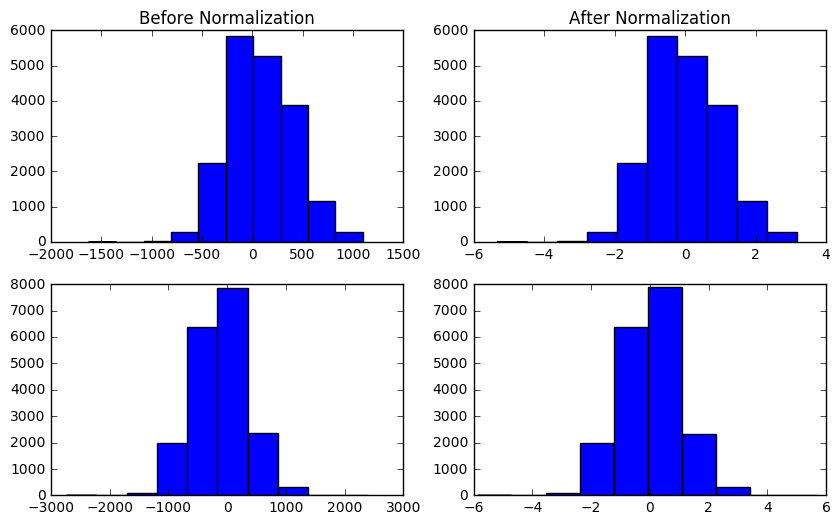

In [96]:
plt.figure(1, figsize=(10, 6))
plt.subplot(222).set_title("After Normalization")
plt.hist(X_train_standardized[:, 8])
plt.subplot(224)
plt.hist(X_train_standardized[:, 23])

plt.subplot(221).set_title("Before Normalization")
plt.hist(a_features_clean[:, 8])
plt.subplot(223)
plt.hist(a_features_clean[:, 23])

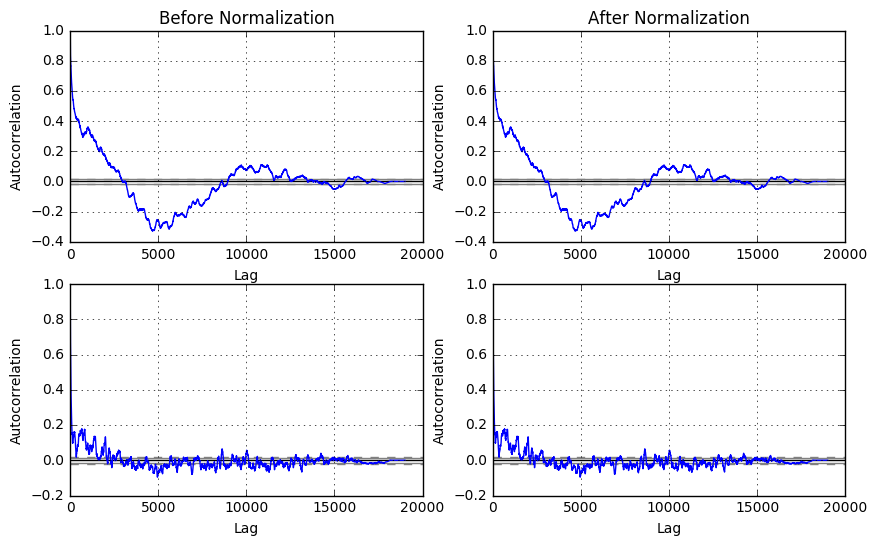

In [104]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
axes[0][0].set_title("Before Normalization")
pd.tools.plotting.autocorrelation_plot(X_train_standardized[:, 8], ax=axes[0][1])
pd.tools.plotting.autocorrelation_plot(X_train_standardized[:, 23], ax=axes[1][1])
axes[0][1].set_title("After Normalization")
pd.tools.plotting.autocorrelation_plot(a_features_clean[:, 8], ax=axes[0][0])
pd.tools.plotting.autocorrelation_plot(a_features_clean[:, 23], ax=axes[1][0])

# 2. Feature Extraction (for dataset B)

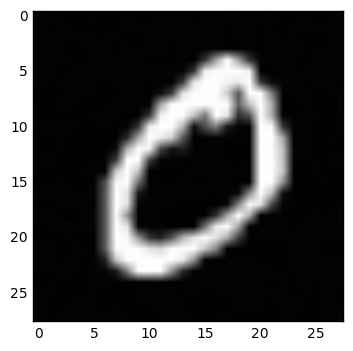

In [267]:
X_train = dataB['fea']
y_train = dataB['gnd'].ravel()

test = X_train[0].reshape(28, 28)
plt.imshow(test, cmap='gray')

## Use PCA for dimensonality reduction

In [211]:
from sklearn.decomposition import PCA

pca = PCA()

pca.fit(X_train)
print(pca.explained_variance_ratio_[:6]) 

pca.components_[:6]

[ 0.13830927  0.082556    0.06319271  0.06083464  0.05080716  0.03832563]


array([[ -3.61067274e-05,  -1.88873948e-05,   1.22686065e-05, ...,
         -1.13194055e-05,   3.02459245e-05,  -8.85748448e-05],
       [  4.10014533e-05,   2.61454773e-05,  -7.18534632e-05, ...,
          2.51662698e-06,   9.63962699e-05,   1.03832848e-04],
       [  4.90102245e-05,   1.02341601e-05,  -5.14355609e-05, ...,
          4.48272573e-05,  -5.97317182e-05,   1.40085757e-05],
       [ -2.04858882e-05,  -6.35089592e-05,  -1.67803330e-05, ...,
          3.95917573e-06,   7.16657261e-05,  -1.89332988e-05],
       [  9.01669554e-05,  -1.49807600e-04,  -2.22957675e-05, ...,
          8.38943023e-07,   8.50944488e-05,  -4.88962076e-05],
       [ -8.72302816e-05,   2.30376786e-05,   8.21707290e-05, ...,
          1.53171236e-04,  -8.63838182e-05,  -2.04125187e-04]])

## Plot 2-d representation of points

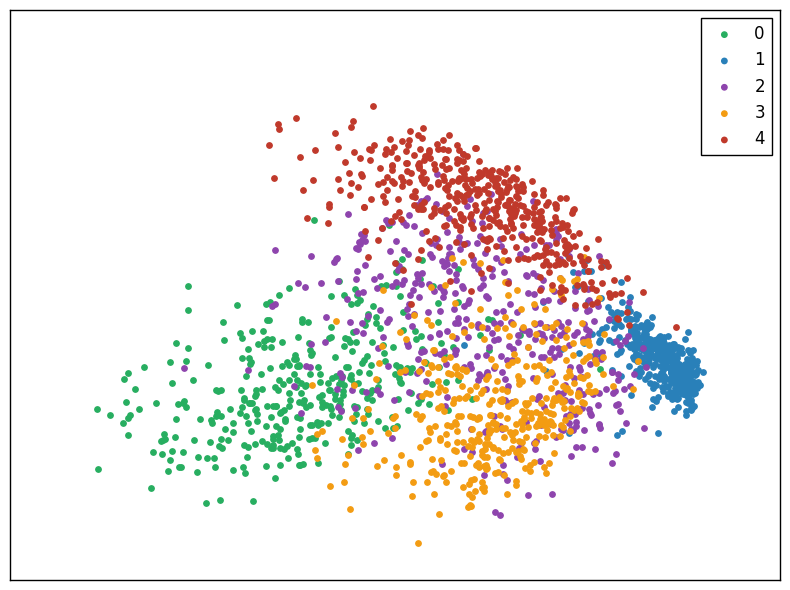

In [194]:
fig, plot = plt.subplots(figsize=(8, 6))
#fig.set_size_inches(25, 25)
plt.prism()

X_transformed = pca.fit_transform(X_train)
colors = [
    ('#27ae60', 'o'),
    ('#2980b9', 'o'),
    ('#8e44ad', 'o'),
    ('#f39c12', 'o'),
    ('#c0392b', 'o'),
]
labels = np.unique(y_train)
for num in range(len(labels)):
    plt.scatter([X_transformed[:,0][i] for i in range(len(y_train)) if y_train[i] == num],
    [X_transformed[:,1][i] for i in range(len(y_train)) if y_train[i] == num], 15,
    label=str(num), color = colors[num][0], marker=colors[num][1])#, edgecolors='black')
    
plt.legend(scatterpoints=1)
plot.set_xticks(())
plot.set_yticks(())
plt.tight_layout()

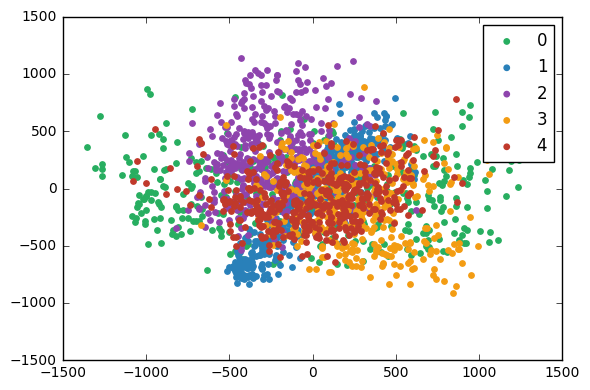

In [212]:
for num in range(len(labels)):
    plt.scatter([X_transformed[:,4][i] for i in range(len(y_train)) if y_train[i] == num],
    [X_transformed[:,5][i] for i in range(len(y_train)) if y_train[i] == num], 15,
    label=str(num), color = colors[num][0], marker=colors[num][1])#, edgecolors='black')
    
plt.legend(scatterpoints=1)
plot.set_xticks(())
plot.set_yticks(())
plt.tight_layout()

In [252]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
y_train = y_train.ravel()
error_rates = []
components = [2, 4, 10, 30, 60, 200, 500, 784]

for component in components:
    X_train = X_transformed[:, :component]
    gnb.fit(X_train, y_train)
    y_pred = gnb.predict(X_train)
    error_rate = (y_pred != y_train).mean()
    error_rates.append(error_rate)
    print("Error rate: %.2f (%d components)" % (error_rate, component))


Error rate: 0.24 (2 components)
Error rate: 0.16 (4 components)
Error rate: 0.07 (10 components)
Error rate: 0.06 (30 components)
Error rate: 0.05 (60 components)
Error rate: 0.06 (200 components)
Error rate: 0.19 (500 components)
Error rate: 0.23 (784 components)


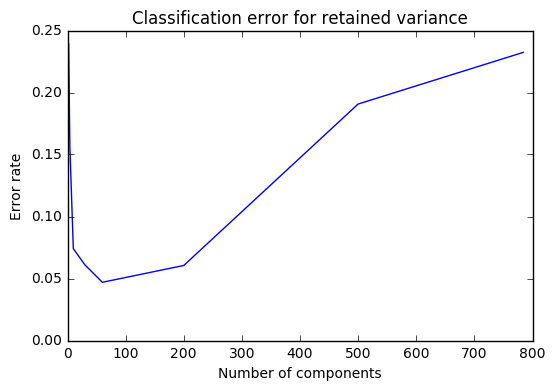

In [282]:
plt.plot(components, error_rates)
plt.xlabel("Number of components")
plt.ylabel("Error rate")
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import LocallyLinearEmbedding

plt.title("Classification error for retained variance")

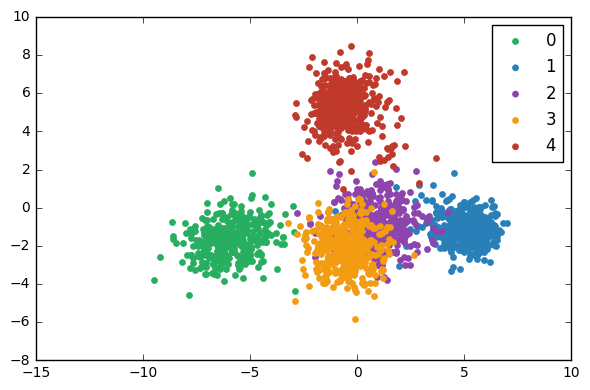

In [271]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2)
X_transformed = lda.fit_transform(X_train, y_train)

for num in range(len(labels)):
    plt.scatter([X_transformed[:,0][i] for i in range(len(y_train)) if y_train[i] == num],
    [X_transformed[:,1][i] for i in range(len(y_train)) if y_train[i] == num], 15,
    label=str(num), color = colors[num][0], marker=colors[num][1])#, edgecolors='black')
    
plt.legend(scatterpoints=1)
plot.set_xticks(())
plot.set_yticks(())
plt.tight_layout()

# 3. Nonlinear Dimensionality Reduction (for dataset B)

## Applying LLE to image of digit 3

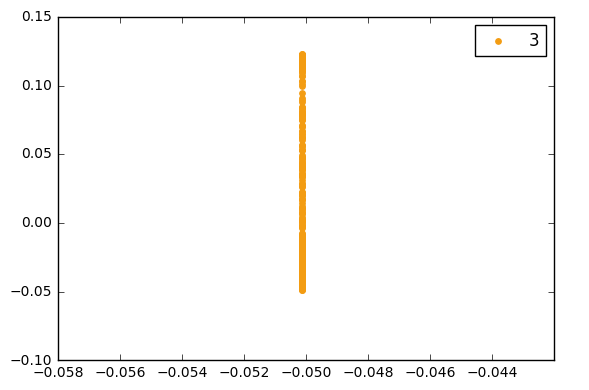

In [283]:
from sklearn.manifold import LocallyLinearEmbedding

X_train = X_train[y_train == 3]
y_train = y_train[y_train == 3]

lle = LocallyLinearEmbedding(n_components=4, n_neighbors=5)

X_transformed = lle.fit_transform(X_train)

num = 3
plt.scatter([X_transformed[:,0][i] for i in range(len(y_train)) if y_train[i] == num],
[X_transformed[:,1][i] for i in range(len(y_train)) if y_train[i] == num], 15,
label=str(num), color = colors[num][0], marker=colors[num][1])#, edgecolors='black')
    
plt.legend(scatterpoints=1)
plot.set_xticks(())
plot.set_yticks(())
plt.tight_layout()

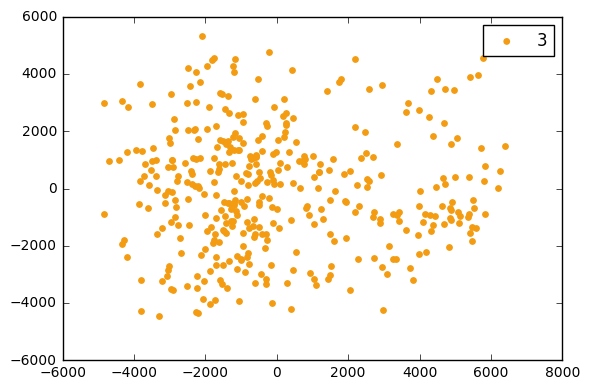

In [293]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=4, n_neighbors=5)
X_transformed = isomap.fit_transform(X_train)

num = 3
plt.scatter([X_transformed[:,0][i] for i in range(len(y_train)) if y_train[i] == num],
[X_transformed[:,1][i] for i in range(len(y_train)) if y_train[i] == num], 15,
label=str(num), color = colors[num][0], marker=colors[num][1])#, edgecolors='black')
    
plt.legend(scatterpoints=1)
plot.set_xticks(())
plot.set_yticks(())
plt.tight_layout()

In [296]:
gnb = GaussianNB()

X_train = dataB['fea']
y_train = dataB['gnd'].ravel()

lle = LocallyLinearEmbedding(n_components=4, n_neighbors=5)

X_transformed = lle.fit_transform(X_train)

gnb.fit(X_transformed, y_train)

y_pred = gnb.predict(X_transformed)
error_rate = (y_pred != y_train).mean()

print("LLE Error Rate:", error_rate)

LLE Error Rate: 0.0788964181994
